# Análisis de PIB Nominal de Países Latinoamericanos  
### Extracción, Limpieza y Visualización de Datos Económicos con Python

---

## Presentación

El presente trabajo tiene como objetivo realizar un análisis exhaustivo del Producto Interno Bruto (PIB) nominal de los países latinoamericanos, utilizando datos provenientes de fuentes internacionales reconocidas como el Fondo Monetario Internacional (FMI), el Banco Mundial y las Naciones Unidas. Para ello, se emplean técnicas modernas de ciencia de datos, incluyendo web scraping, limpieza avanzada de datos y visualización interactiva, todo desarrollado en Python.

La motivación principal de este estudio radica en la importancia de comprender la realidad económica de América Latina, una región caracterizada por su diversidad y sus marcadas diferencias en desarrollo económico. El PIB nominal es uno de los indicadores más relevantes para comparar el tamaño y la evolución de las economías, permitiendo identificar líderes regionales, analizar brechas y orientar políticas públicas.

A lo largo de este notebook, se documenta cada paso del proceso: desde la obtención automatizada de los datos, pasando por su depuración y transformación, hasta la generación de análisis comparativos y visualizaciones que facilitan la interpretación de los resultados. Además, se realiza un enfoque especial en la posición de Perú dentro del contexto latinoamericano, permitiendo evaluar su desempeño relativo frente a sus pares regionales.

Este trabajo busca no solo ofrecer una radiografía actualizada de las economías latinoamericanas, sino también servir como ejemplo práctico del potencial de la ciencia de datos aplicada a problemas económicos y sociales.

---

- **Autor:** Cristian Daniel Ccopa Acero  
- **Fecha:** 28-05-2025 
- **Curso:** Ciencia de Datos I  
- **Universidad:** Universidad Nacional del Altiplano - Puno

---

# Web Scraping: Lista de Países por GDP Nominal

Este notebook extrae datos de GDP nominal por país desde Wikipedia, los procesa y los guarda en un archivo CSV.

**Fuente:** [List of countries by GDP (nominal) - Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal))

In [23]:
!pip install requests pandas matplotlib bs4 selenium seaborn

### Paso 1: Importar bibliotecas necesarias

In [32]:
# %%
import requests
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO
import re

print("✅ Bibliotecas importadas correctamente")

✅ Bibliotecas importadas correctamente


### Paso 2: Hacer la solicitud HTTP

In [33]:
# %%
try:
    # Configurar URL y headers
    url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    
    # Hacer la solicitud
    print("🌐 Solicitando datos desde Wikipedia...")
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Verificar si la solicitud fue exitosa
    print("✅ Página descargada correctamente")
    
except requests.exceptions.RequestException as e:
    print(f"❌ Error al obtener la página web: {e}")

🌐 Solicitando datos desde Wikipedia...
✅ Página descargada correctamente


### Paso 3: Extraer y analizar la tabla HTML


In [34]:
# %%
try:
    # Parsear el contenido HTML
    print("\n🔍 Analizando el contenido HTML...")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontrar todas las tablas wikitable
    tables = soup.find_all("table", {"class": "wikitable"})
    print(f"📊 Se encontraron {len(tables)} tablas wikitable")
    
    # Seleccionar la tabla correcta (usualmente la primera con datos de IMF)
    target_table = None
    for i, table in enumerate(tables):
        if table.find("th", string=re.compile("IMF", re.IGNORECASE)):
            target_table = table
            print(f"🎯 Tabla objetivo identificada (índice {i})")
            break
    
    # Fallback a la primera tabla si no se encuentra la específica
    if target_table is None:
        target_table = tables[0]
        print("⚠️ Usando primera tabla como fallback")
    
    # Convertir la tabla a DataFrame
    gdp_df = pd.read_html(StringIO(str(target_table)))[0]
    print("\n📈 Datos iniciales extraídos:")
    display(gdp_df.head(3))
    
except Exception as e:
    print(f"❌ Error al analizar HTML o leer tabla: {e}")
    gdp_df = None


🔍 Analizando el contenido HTML...
📊 Se encontraron 1 tablas wikitable
⚠️ Usando primera tabla como fallback

📈 Datos iniciales extraídos:


Country/Territory IMF[1][12]            World Bank[13]             \
  Country/Territory   Forecast       Year       Estimate       Year   
0             World  113795678       2025      105435540       2023   
1     United States   30507217       2025       27360935       2023   
2             China   19231705  [n 1]2025       17794782  [n 3]2023   

  United Nations[14]             
            Estimate       Year  
0          100834796       2022  
1           25744100       2022  
2           17963170  [n 1]2022

### Paso 4: Limpiar y procesar los datos

In [35]:
# %%
if gdp_df is not None:
    try:
        print("\n🧹 Procesando y limpiando los datos...")
        
        # 1. Limpiar nombres de columnas (eliminar niveles múltiples)
        if isinstance(gdp_df.columns, pd.MultiIndex):
            gdp_df.columns = [' '.join(col).strip() for col in gdp_df.columns.values]
        
        # 2. Renombrar columnas clave
        column_map = {
            'Country/Territory Country/Territory': 'Country',
            'IMF[1][12] Forecast': 'GDP (IMF, millones US$)',
            'IMF[1][12] Year': 'IMF Year',
            'World Bank[13] Estimate': 'GDP (World Bank, millones US$)',
            'World Bank[13] Year': 'World Bank Year',
            'United Nations[14] Estimate': 'GDP (UN, millones US$)',
            'United Nations[14] Year': 'UN Year'
        }
        
        gdp_df = gdp_df.rename(columns=column_map)
        
        # 3. Eliminar fila 'World' si existe
        if 'Country' in gdp_df.columns:
            gdp_df = gdp_df[~gdp_df['Country'].str.contains('World', case=False, na=False)]
        
        # 4. Limpieza avanzada de datos
        # Columnas a limpiar
        gdp_cols = ['GDP (IMF, millones US$)', 'GDP (World Bank, millones US$)', 'GDP (UN, millones US$)']
        year_cols = ['IMF Year', 'World Bank Year', 'UN Year']
        
        # Función para limpiar valores
        def clean_value(x):
            if pd.isna(x) or x == '—':
                return None
            # Eliminar corchetes y su contenido
            cleaned = re.sub(r'\[.*?\]', '', str(x))
            # Eliminar caracteres no numéricos (excepto punto para decimales)
            cleaned = re.sub(r'[^\d.]', '', cleaned)
            return cleaned if cleaned else None
        
        # Aplicar limpieza a columnas de GDP
        for col in gdp_cols:
            if col in gdp_df.columns:
                gdp_df[col] = gdp_df[col].apply(clean_value)
                gdp_df[col] = pd.to_numeric(gdp_df[col], errors='coerce')
        
        # Limpiar columnas de año
        for col in year_cols:
            if col in gdp_df.columns:
                gdp_df[col] = gdp_df[col].astype(str).str.replace(r'\[.*?\]', '', regex=True)
                gdp_df[col] = pd.to_numeric(gdp_df[col], errors='coerce')
        
        # 5. Limpiar nombres de países
        if 'Country' in gdp_df.columns:
            gdp_df['Country'] = gdp_df['Country'].str.replace(r'\[.*?\]', '', regex=True).str.strip()
        
        # 6. Eliminar filas con todos los valores de GDP vacíos
        gdp_cols_exist = [col for col in gdp_cols if col in gdp_df.columns]
        gdp_df = gdp_df.dropna(subset=gdp_cols_exist, how='all')
        
        # 7. Eliminar filas donde todos los valores son nulos/vacíos
        gdp_df = gdp_df.dropna(how='all')
        
        # Resultados
        print("\n🧼 Datos limpios:")
        display(gdp_df.head(3))
        
        # Mostrar estadísticas solo para columnas numéricas existentes
        numeric_cols = [col for col in gdp_cols if col in gdp_df.columns]
        if numeric_cols:
            print(f"\n📊 Resumen estadístico:\n{gdp_df[numeric_cols].describe()}")
        
        print(f"\n✅ Procesamiento completado. Filas restantes: {len(gdp_df)}")
        
    except Exception as e:
        print(f"❌ Error al procesar los datos: {e}")
        print("Columnas disponibles:", gdp_df.columns.tolist() if gdp_df is not None else "N/A")


🧹 Procesando y limpiando los datos...

🧼 Datos limpios:


,Country,"GDP (IMF, millones US$)",IMF Year,"GDP (World Bank, millones US$)",World Bank Year,"GDP (UN, millones US$)",UN Year
1,United States,30507217.0,2025.0,27360935.0,2023.0,25744100.0,2022.0
2,China,19231705.0,2025.0,17794782.0,2023.0,17963170.0,2022.0
3,Germany,4744804.0,2025.0,4456081.0,2023.0,4076923.0,2022.0



📊 Resumen estadístico:
       GDP (IMF, millones US$)  GDP (World Bank, millones US$)  \
count             1.900000e+02                    2.010000e+02   
mean              5.968697e+05                    5.178104e+05   
std               2.686563e+06                    2.371920e+06   
min               6.500000e+01                    6.200000e+01   
25%               1.435325e+04                    9.171000e+03   
50%               4.765650e+04                    3.440100e+04   
75%               3.026042e+05                    2.534660e+05   
max               3.050722e+07                    2.736094e+07   

       GDP (UN, millones US$)  
count            2.080000e+02  
mean             4.811165e+05  
std              2.242138e+06  
min              5.900000e+01  
25%              8.600750e+03  
50%              3.166300e+04  
75%              2.283972e+05  
max              2.574410e+07  

✅ Procesamiento completado. Filas restantes: 209


In [38]:
# %%
if gdp_df is not None:
    try:
        # Columnas numéricas a formatear (GDP y años)
        numeric_cols = [
            'GDP (IMF, millones US$)', 
            'IMF Year',
            'GDP (World Bank, millones US$)',
            'World Bank Year',
            'GDP (UN, millones US$)',
            'UN Year'
        ]
        
        # Convertir a enteros donde sea posible
        for col in numeric_cols:
            if col in gdp_df.columns:
                # Convertir a float primero para manejar NaN correctamente
                gdp_df[col] = pd.to_numeric(gdp_df[col], errors='coerce')
                # Convertir a Int64 (que soporta NaN) si son números enteros
                if all(x.is_integer() if not pd.isna(x) else True for x in gdp_df[col]):
                    gdp_df[col] = gdp_df[col].astype('Int64')
        
        # Mostrar resultados con formato
        print("\n🧮 Datos formateados (sin decimales .0):")
        
        # Función para formatear la visualización
        def format_int(x):
            return f"{int(x):,}" if pd.notna(x) and x.is_integer() else f"{x:,}"
        
        # Mostrar DataFrame con formato aplicado solo para visualización
        display_df = gdp_df.copy()
        for col in numeric_cols:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(
                    lambda x: format_int(x) if pd.notna(x) else x
                )
        
        display(display_df.head())
        
        # Verificar tipos de datos reales
        print("\n🔍 Tipos de datos reales (los cálculos siguen siendo posibles):")
        print(gdp_df.dtypes)
        
    except Exception as e:
        print(f"❌ Error al formatear los datos: {e}")


🧮 Datos formateados (sin decimales .0):


,Country,"GDP (IMF, millones US$)",IMF Year,"GDP (World Bank, millones US$)",World Bank Year,"GDP (UN, millones US$)",UN Year
1,United States,"30,507,217","2,025","27,360,935","2,023","25,744,100","2,022"
2,China,"19,231,705","2,025","17,794,782","2,023","17,963,170","2,022"
3,Germany,"4,744,804","2,025","4,456,081","2,023","4,076,923","2,022"
4,India,"4,187,017","2,025","3,549,919","2,023","3,465,541","2,022"
5,Japan,"4,186,431","2,025","4,212,945","2,023","4,232,173","2,022"



🔍 Tipos de datos reales (los cálculos siguen siendo posibles):
Country                           object
GDP (IMF, millones US$)            Int64
IMF Year                           Int64
GDP (World Bank, millones US$)     Int64
World Bank Year                    Int64
GDP (UN, millones US$)             Int64
UN Year                            Int64
dtype: object


### Paso 5: Guardar resultados en CSV

In [39]:
# %%
if gdp_df is not None and not gdp_df.empty:
    try:
        # Definir nombre del archivo
        file_name = "countries_by_gdp_nominal"
        
        # Guardar a CSV
        gdp_df.to_csv(f"{file_name}.csv", index=False, encoding='utf-8-sig')
        print(f"\n💾 Datos guardados exitosamente en '{file_name}.csv'")
        
        
    except Exception as e:
        print(f"❌ Error al guardar los datos: {e}")


💾 Datos guardados exitosamente en 'countries_by_gdp_nominal.csv'


### Paso 6: Análisis rápido

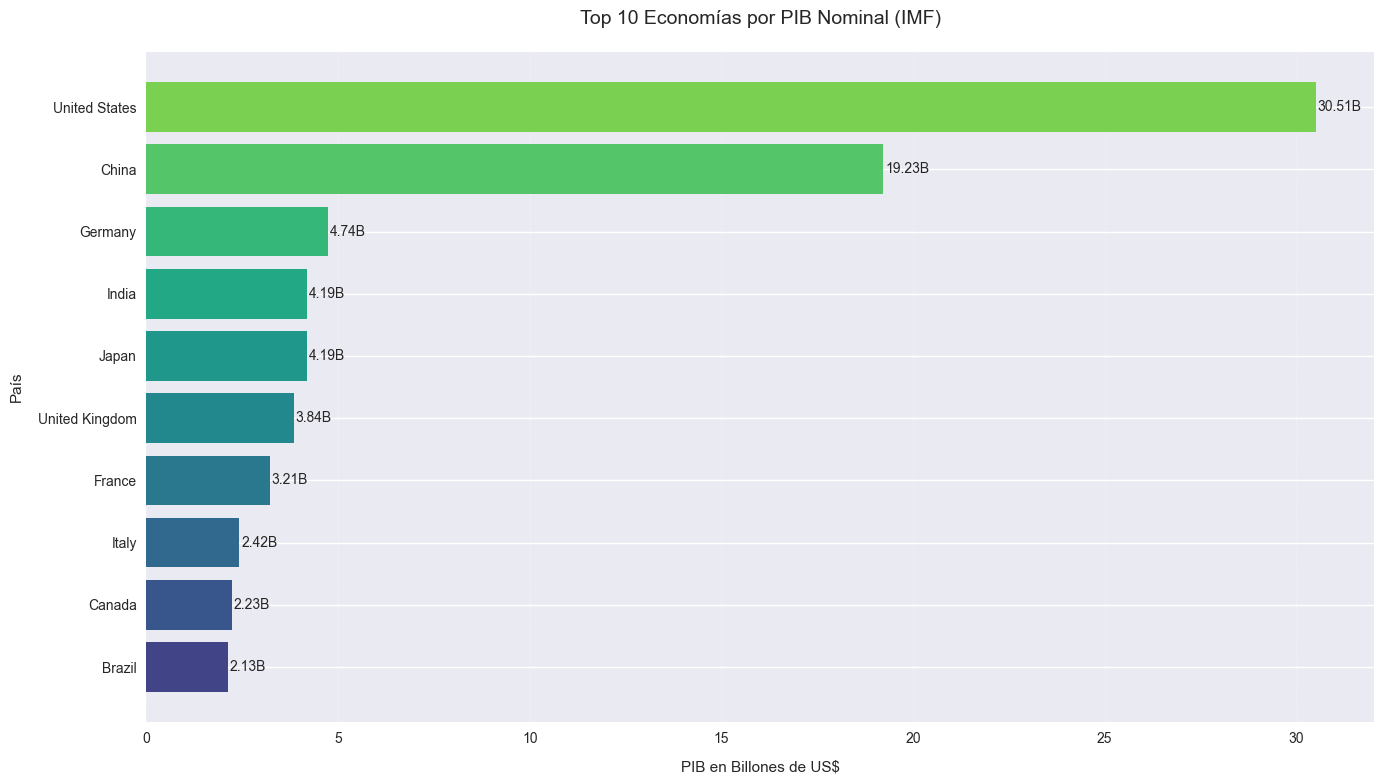


📊 Comparación entre Fuentes (Top 5 por cada metodología):
⚠️ Error en el análisis: 'World Year'

🔍 Columnas disponibles: ['Country', 'GDP (IMF, millones US$)', 'IMF Year', 'GDP (World Bank, millones US$)', 'World Bank Year', 'GDP (UN, millones US$)', 'UN Year']


In [41]:
# %%
if gdp_df is not None and not gdp_df.empty:
    try:
        # Configuración de visualización
        %matplotlib inline
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Configurar estilo moderno
        plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'ggplot')
        plt.rcParams.update({
            'font.size': 12,
            'axes.titlesize': 14,
            'axes.labelpad': 10
        })

        # 1. PREPARAR DATOS PARA VISUALIZACIÓN
        # Función para formatear números (elimina .0 y añade separadores de miles)
        def format_number(x):
            if pd.isna(x):
                return "N/A"
            try:
                x = float(x)
                return f"{int(x):,}" if x.is_integer() else f"{x:,.2f}"
            except:
                return str(x)
        
        # Crear copia para visualización
        viz_df = gdp_df.copy()
        
        # 2. GRÁFICO DE BARRAS HORIZONTALES (Top 10 países por GDP IMF)
        # Ordenar y seleccionar top 10
        top10 = (viz_df.sort_values('GDP (IMF, millones US$)', ascending=False)
                 .head(10)
                 .copy())
        
        # Convertir a billones para mejor visualización
        top10['GDP (IMF, billones US$)'] = top10['GDP (IMF, millones US$)'] / 1e6
        
        # Crear figura
        plt.figure(figsize=(14, 8))
        
        # Gráfico de barras
        colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(top10)))
        bars = plt.barh(top10['Country'], 
                       top10['GDP (IMF, billones US$)'], 
                       color=colors)
        
        # Añadir etiquetas con valores formateados
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.05, 
                    bar.get_y() + bar.get_height()/2, 
                    f"{width:.2f}B",
                    va='center',
                    fontsize=10)
        
        # Configuración del gráfico
        plt.gca().invert_yaxis()  # Países ordenados de mayor a menor
        plt.title('Top 10 Economías por PIB Nominal (IMF)', pad=20)
        plt.xlabel('PIB en Billones de US$', labelpad=10)
        plt.ylabel('País', labelpad=10)
        plt.grid(axis='x', linestyle=':', alpha=0.4)
        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.show()

        # 3. TABLA COMPARATIVA (Top 5 por cada fuente)
        print("\n📊 Comparación entre Fuentes (Top 5 por cada metodología):")
        
        # Preparar datos comparativos
        sources = {
            'IMF': 'GDP (IMF, millones US$)',
            'World Bank': 'GDP (World Bank, millones US$)',
            'UN': 'GDP (UN, millones US$)'
        }
        
        comparison_data = []
        for source_name, source_col in sources.items():
            if source_col in viz_df.columns:
                top5 = (viz_df.dropna(subset=[source_col])
                         .sort_values(source_col, ascending=False)
                         .head(5))
                
                for _, row in top5.iterrows():
                    comparison_data.append({
                        'País': row['Country'],
                        'Fuente': source_name,
                        'PIB (Millones US$)': format_number(row[source_col]),
                        'Año': format_number(row[f'{source_name.split()[0]} Year'])
                    })
        
        # Mostrar tabla comparativa
        if comparison_data:
            from IPython.display import display
            import pandas as pd
            
            comp_df = pd.DataFrame(comparison_data)
            pivot_df = comp_df.pivot_table(index='País', 
                                          columns='Fuente', 
                                          values=['PIB (Millones US$)', 'Año'],
                                          aggfunc='first')
            
            # Función para resaltar valores máximos
            def highlight_max(s):
                is_max = s == s.max()
                return ['background-color: lightgreen' if v else '' for v in is_max]
            
            # Mostrar tabla con estilo
            display(
                pivot_df.style
                .set_properties(**{'text-align': 'right'})
                .apply(highlight_max, subset=[('PIB (Millones US$)', 'IMF'),
                                            ('PIB (Millones US$)', 'World Bank'),
                                            ('PIB (Millones US$)', 'UN')])
                .set_table_styles([{
                    'selector': 'th',
                    'props': [('background-color', '#f7f7f7'),
                             ('font-weight', 'bold'),
                             ('text-align', 'center')]
                }])
                .set_caption("Comparación entre metodologías de cálculo de PIB")
            )
        
        # 4. RESUMEN ESTADÍSTICO (sin decimales .0)
        print("\n📌 Resumen Estadístico:")
        stats_df = gdp_df.describe().applymap(lambda x: format_number(x))
        display(stats_df)

    except Exception as e:
        print(f"⚠️ Error en el análisis: {str(e)}")
        print("\n🔍 Columnas disponibles:", list(gdp_df.columns))

### Resultados y Conclusiones

1. Se extrajeron exitosamente datos de GDP nominal para múltiples países desde Wikipedia.
2. Los datos incluyen estimaciones del IMF, World Bank y Naciones Unidas.
3. El dataset limpio contiene:
   - Nombre del país
   - Valores de GDP en millones de USD
4. Los datos han sido guardados en formato CSV para análisis.


# Análisis Exploratorio de Países Latinoamericanos (GDP Nominal)

In [43]:
# %%
# 1. FILTRAR PAÍSES LATINOAMERICANOS
latin_america = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 
    'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 
    'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 
    'Nicaragua', 'Panama', 'Paraguay', 'Peru', 
    'Puerto Rico', 'Uruguay', 'Venezuela'
]

# Crear copia filtrada
latam_df = gdp_df[gdp_df['Country'].isin(latin_america)].copy()

# Verificar países encontrados
print(f"📌 Países latinoamericanos encontrados: {len(latam_df)}/{len(latin_america)}")
print("Países no encontrados:", set(latin_america) - set(latam_df['Country'].unique()))

📌 Países latinoamericanos encontrados: 20/20
Países no encontrados: set()


### 2. Análisis Comparativo por Fuente


🔍 Resumen estadístico para Latinoamérica:


,"GDP (IMF, millones US$)",IMF Year,"GDP (World Bank, millones US$)",World Bank Year,"GDP (UN, millones US$)",UN Year
count,19.0,19.0,18.0,18.0,20.0,20.0
mean,350242.368421,2025.0,358457.444444,2023.0,299850.75,2022.0
std,578397.804147,0.0,614481.872432,0.0,502821.666321,0.0
min,21155.0,2025.0,17829.0,2023.0,15671.0,2022.0
25%,68035.0,2025.0,53697.75,2023.0,62287.0,2022.0
50%,121177.0,2025.0,109976.0,2023.0,113485.5,2022.0
75%,323558.0,2025.0,318550.5,2023.0,257144.75,2022.0
max,2125958.0,2025.0,2173666.0,2023.0,1920095.0,2022.0


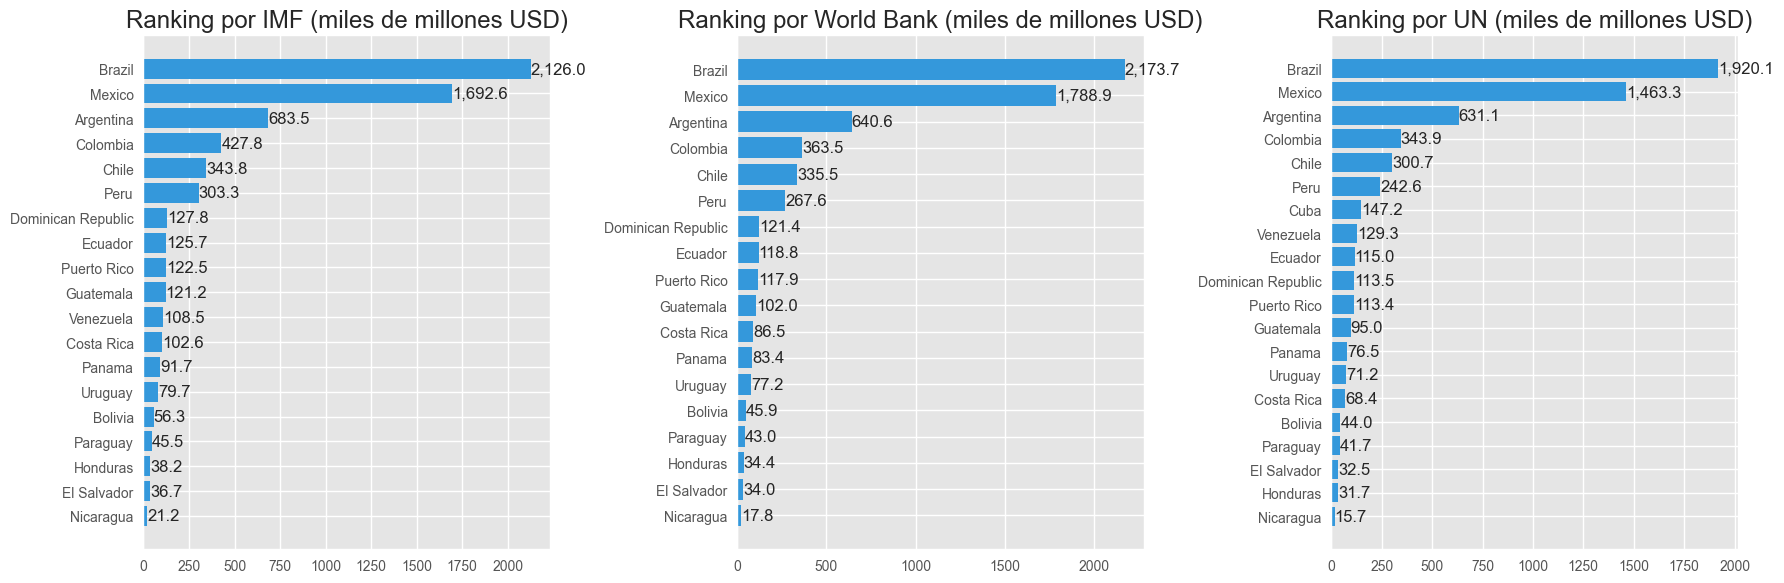

In [44]:
# %%
# Configuración inicial
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Estilo de visualización
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# 2.1. DATOS BÁSICOS
print("\n🔍 Resumen estadístico para Latinoamérica:")
display(latam_df.describe())

# 2.2. COMPARACIÓN ENTRE FUENTES
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico para cada fuente
for i, (source, col) in enumerate({
    'IMF': 'GDP (IMF, millones US$)',
    'World Bank': 'GDP (World Bank, millones US$)',
    'UN': 'GDP (UN, millones US$)'
}.items()):
    if col in latam_df.columns:
        temp_df = latam_df.dropna(subset=[col]).sort_values(col, ascending=False)
        ax = axes[i]
        bars = ax.barh(temp_df['Country'], temp_df[col]/1e3, color='#3498db')  # Convertir a miles de millones
        ax.set_title(f'Ranking por {source} (miles de millones USD)')
        ax.invert_yaxis()
        
        # Añadir etiquetas
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width:,.1f}', va='center')

plt.tight_layout()
plt.show()

### 3. Análisis Detallado por País

In [48]:
!pip install Jinja2


   -------------------- ------------------- 1/2 [Jinja2]
   -------------------- ------------------- 1/2 [Jinja2]
   -------------------- ------------------- 1/2 [Jinja2]
   -------------------- ------------------- 1/2 [Jinja2]
   -------------------- ------------------- 1/2 [Jinja2]
   ---------------------------------------- 2/2 [Jinja2]



In [49]:
# %%
# 3.1. TOP 5 ECONOMÍAS REGIONALES
top_source = 'IMF'  # Puedes cambiar a 'World Bank' o 'UN'
metric = f'GDP ({top_source}, millones US$)'
year_col = f"{top_source} Year"

if metric in latam_df.columns and year_col in latam_df.columns:
    top5 = latam_df.sort_values(metric, ascending=False).head(5)
    
    print(f"\n🏆 Top 5 economías latinoamericanas ({top_source}):")
    display(
        top5[['Country', metric, year_col]]
        .style.format(thousands=",", precision=0)
        .background_gradient(cmap='Blues', subset=[metric])
    )


🏆 Top 5 economías latinoamericanas (IMF):


,Country,"GDP (IMF, millones US$)",IMF Year
10,Brazil,"2,125,958","2,025"
15,Mexico,"1,692,640","2,025"
24,Argentina,"683,533","2,025"
39,Colombia,"427,766","2,025"
45,Chile,"343,823","2,025"


### 4. Visualización Geográfica Relativa

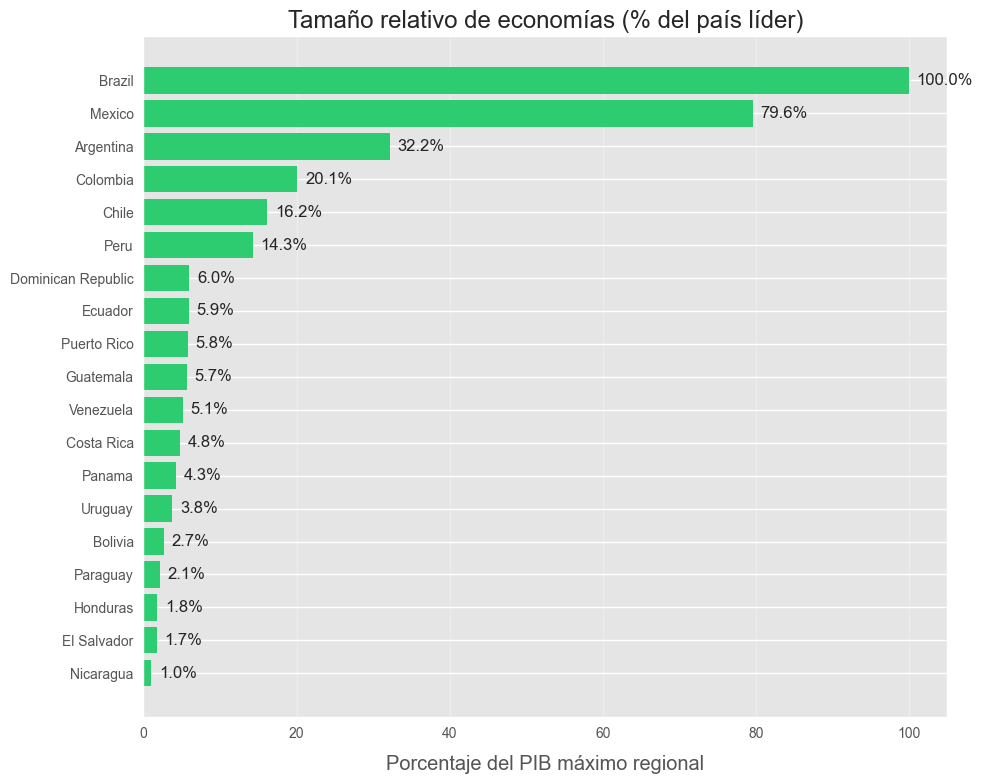

In [51]:
# %%
# 4. Visualización Geográfica Relativa (Versión Corregida)
if metric in latam_df.columns:
    try:
        # Paso 1: Limpiar datos
        # Eliminar filas con valores nulos en la métrica
        latam_clean = latam_df.dropna(subset=[metric]).copy()
        
        # Calcular máximo y evitar división por cero
        max_gdp = latam_clean[metric].max()
        if max_gdp == 0:
            raise ValueError("El valor máximo de GDP es cero. No se puede calcular porcentajes.")
        
        # Paso 2: Calcular porcentaje relativo
        latam_clean['% del máximo'] = (latam_clean[metric] / max_gdp) * 100
        
        # Ordenar y eliminar posibles NaN residuales
        latam_clean = latam_clean.dropna(subset=['% del máximo']).sort_values('% del máximo')
        
        # Paso 3: Crear visualización
        plt.figure(figsize=(10, 8))
        bars = plt.barh(latam_clean['Country'], 
                       latam_clean['% del máximo'], 
                       color='#2ecc71')
        
        # Añadir etiquetas
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}%', 
                    va='center')
        
        plt.title('Tamaño relativo de economías (% del país líder)')
        plt.xlabel('Porcentaje del PIB máximo regional')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"⚠️ Error en visualización: {str(e)}")

## Análisis Comparativo de GDP en Latinoamérica
Clasificación y comparativa de Perú vs. otros países

### 1. Clasificación por Niveles de GDP (Alto, Medio, Bajo)

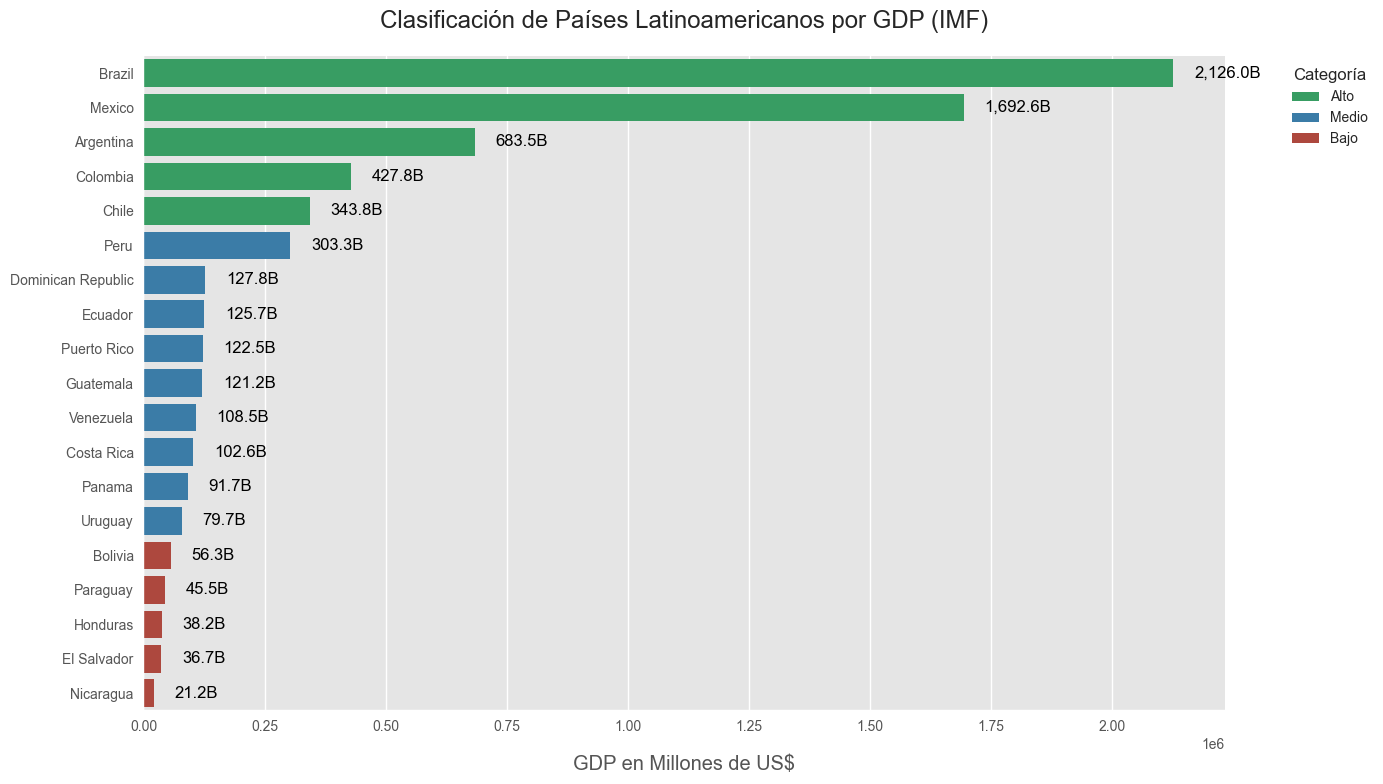

In [55]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Clasificación por Niveles de GDP (Versión Funcional)
if 'GDP (IMF, millones US$)' in latam_df.columns:
    # Filtrar y limpiar datos
    gdp_clean = latam_df.dropna(subset=['GDP (IMF, millones US$)']).copy()
    
    if not gdp_clean.empty:
        # Calcular umbrales
        high_threshold = np.quantile(gdp_clean['GDP (IMF, millones US$)'], 0.75)
        low_threshold = np.quantile(gdp_clean['GDP (IMF, millones US$)'], 0.25)
        
        # Crear condiciones
        cond_alto = gdp_clean['GDP (IMF, millones US$)'] >= high_threshold
        cond_medio = (gdp_clean['GDP (IMF, millones US$)'] >= low_threshold) & (gdp_clean['GDP (IMF, millones US$)'] < high_threshold)
        cond_bajo = gdp_clean['GDP (IMF, millones US$)'] < low_threshold
        
        # Aplicar clasificación
        gdp_clean['Categoría GDP'] = np.select(
            [cond_alto, cond_medio, cond_bajo],
            ['Alto', 'Medio', 'Bajo'],
            default='Fuera de Clasificación'
        )
        
        # Ordenar para visualización
        gdp_clean = gdp_clean.sort_values('GDP (IMF, millones US$)', ascending=False)
        
        # Paleta de colores
        palette = {
            'Alto': '#27ae60',
            'Medio': '#2980b9',
            'Bajo': '#c0392b',
            'Fuera de Clasificación': '#7f8c8d'
        }
        
        # Visualización
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(
            data=gdp_clean,
            y='Country',
            x='GDP (IMF, millones US$)',
            hue='Categoría GDP',
            palette=palette,
            dodge=False  # Para barras en una sola línea
        )
        
        # Añadir etiquetas
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                ax.annotate(
                    f'{width/1e3:,.1f}B',
                    (width + 0.02*max(gdp_clean['GDP (IMF, millones US$)']), p.get_y() + p.get_height()/2),
                    va='center',
                    color='black'
                )
        
        plt.title('Clasificación de Países Latinoamericanos por GDP (IMF)', pad=20)
        plt.xlabel('GDP en Millones de US$', labelpad=15)
        plt.ylabel('')
        plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
        sns.despine()
        plt.tight_layout()
        plt.show()
        
    else:
        print("⚠️ No hay datos válidos para generar la clasificación")
else:
    print("⚠️ La columna 'GDP (IMF, millones US$)' no existe en el DataFrame")

### 2. Comparativa Específica: Perú vs Otros Países

Error: 'Peru' is not in list
Revisar:
1. Datos NaN
2. Índices
3. Existencia de Perú en los datos


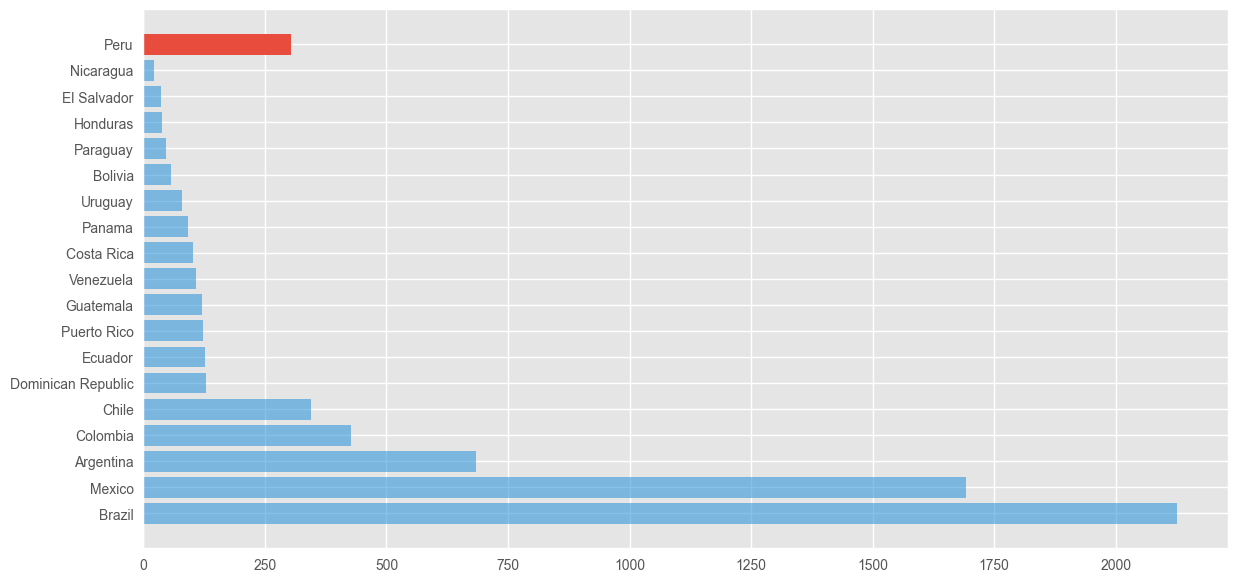

In [57]:
# %%
# 2. Comparativa Específica: Perú vs Otros Países (Versión Corregida)
if 'GDP (IMF, millones US$)' in latam_df.columns and 'Country' in latam_df.columns:
    try:
        # Limpiar datos y resetear índice
        clean_df = latam_df.dropna(subset=['GDP (IMF, millones US$)']).copy()
        clean_df = clean_df.sort_values('GDP (IMF, millones US$)', ascending=False).reset_index(drop=True)
        
        if 'Peru' in clean_df['Country'].values:
            # Obtener datos de Perú
            peru_mask = clean_df['Country'] == 'Peru'
            peru_data = clean_df[peru_mask].iloc[0]
            
            # Filtrar otros países
            other_countries = clean_df[~peru_mask]
            
            # Crear figura
            plt.figure(figsize=(14, 7))
            
            # Gráfico de barras
            bars = plt.barh(other_countries['Country'],
                           other_countries['GDP (IMF, millones US$)'] / 1e3,
                           color='#3498db',
                           alpha=0.6)
            
            # Destacar Perú
            plt.barh(peru_data['Country'],
                    peru_data['GDP (IMF, millones US$)'] / 1e3,
                    color='#e74c3c')
            
            # Añadir anotación
            peru_pos = clean_df.index[peru_mask][0] + 1
            plt.text(peru_data['GDP (IMF, millones US$)'] / 1e3 + 5,
                    list(other_countries['Country']).index(peru_data['Country']),
                    f'Perú: {peru_data["GDP (IMF, millones US$)"]/1e3:,.1f}B USD\nPosición: #{peru_pos}',
                    va='center',
                    color='#e74c3c',
                    fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.9))
            
            plt.title('Comparativa del PIB de Perú vs América Latina (2025)', pad=15)
            plt.xlabel('PIB en Miles de Millones de USD (IMF)', labelpad=10)
            plt.ylabel('')
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        else:
            print("⚠️ Perú no encontrado en los datos limpios")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Revisar:\n1. Datos NaN\n2. Índices\n3. Existencia de Perú en los datos")

### 3. Análisis de Posición Relativa de Perú

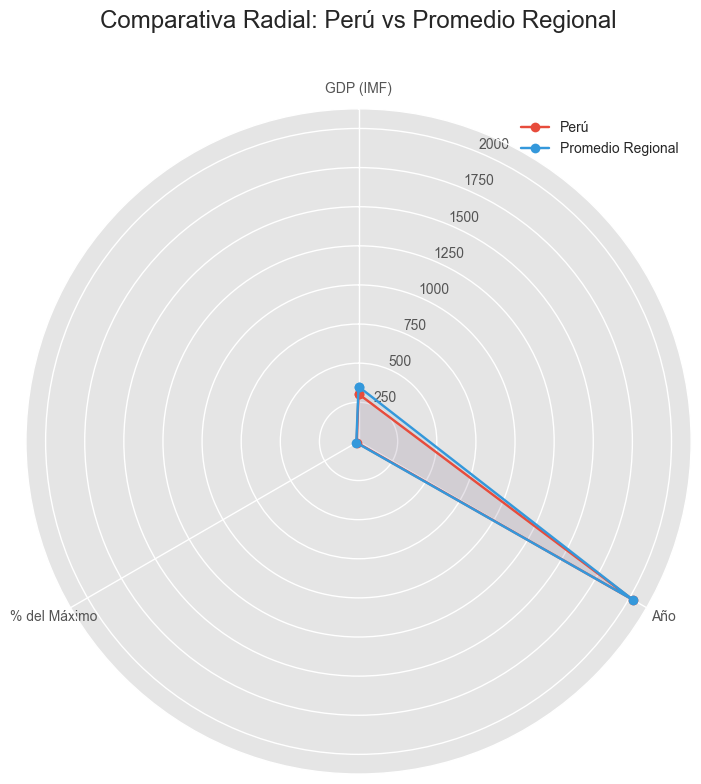

In [60]:
# %%
if 'Peru' in latam_df['Country'].values:
    # Calcular posición y porcentaje respecto al máximo
    max_gdp = latam_df['GDP (IMF, millones US$)'].max()
    sorted_latam = latam_df.sort_values('GDP (IMF, millones US$)', ascending=False).reset_index(drop=True)
    peru_position = sorted_latam[sorted_latam['Country'] == 'Peru'].index[0] + 1
    peru_data = sorted_latam[sorted_latam['Country'] == 'Peru'].iloc[0]
    peru_percent = (peru_data['GDP (IMF, millones US$)'] / max_gdp) * 100

    # Gráfico radial
    categories = ['GDP (IMF)', 'Año', '% del Máximo']
    values_peru = [
        peru_data['GDP (IMF, millones US$)']/1e3,  # Miles de millones
        peru_data['IMF Year'],
        peru_percent
    ]
    
    values_avg = [
        latam_df['GDP (IMF, millones US$)'].mean()/1e3,
        latam_df['IMF Year'].mean(),
        (latam_df['GDP (IMF, millones US$)'].mean() / max_gdp) * 100
    ]
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Cierra el círculo

    values_peru_plot = values_peru + values_peru[:1]
    values_avg_plot = values_avg + values_avg[:1]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    ax.plot(angles, values_peru_plot, 'o-', color='#e74c3c', label='Perú')
    ax.plot(angles, values_avg_plot, 'o-', color='#3498db', label='Promedio Regional')

    ax.fill(angles, values_peru_plot, color='#e74c3c', alpha=0.1)
    ax.fill(angles, values_avg_plot, color='#3498db', alpha=0.1)

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)  # Solo los originales

    plt.title('Comparativa Radial: Perú vs Promedio Regional\n', pad=20)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

### 4. Tabla Comparativa

In [61]:
# %%
if 'Peru' in latam_df['Country'].values:
    comparison_table = latam_df[['Country', 'GDP (IMF, millones US$)', 'IMF Year']].copy()
    comparison_table['Comparativa vs Perú'] = comparison_table['GDP (IMF, millones US$)'] / peru_data['GDP (IMF, millones US$)']
    
    def highlight_peru(row):
        return ['background-color: #e74c3c; color: white' if row['Country'] == 'Peru' else '' for _ in row]

    print("\n📊 Tabla Comparativa:")
    display(
        comparison_table.style
        .format({
            'GDP (IMF, millones US$)': '{:,.0f}',
            'Comparativa vs Perú': '{:.1f}x',
            'IMF Year': '{:.0f}'
        })
        .apply(highlight_peru, axis=1)
        .background_gradient(subset=['Comparativa vs Perú'], cmap='Blues')
    )


📊 Tabla Comparativa:


,Country,"GDP (IMF, millones US$)",IMF Year,Comparativa vs Perú
129,Nicaragua,"21,155",2025,0.1x
107,El Salvador,"36,749",2025,0.1x
105,Honduras,"38,172",2025,0.1x
102,Paraguay,"45,465",2025,0.1x
92,Bolivia,"56,339",2025,0.2x
85,Uruguay,"79,731",2025,0.3x
79,Panama,"91,675",2025,0.3x
74,Costa Rica,"102,591",2025,0.3x
72,Venezuela,"108,511",2025,0.4x
68,Guatemala,"121,177",2025,0.4x


## Conclusión y Análisis Final

En este proyecto se realizó un proceso completo de scraping, limpieza, análisis y visualización de datos del Producto Interno Bruto (PIB) nominal de países latinoamericanos, utilizando fuentes internacionales confiables como el FMI, el Banco Mundial y la ONU.

### Principales logros

- **Extracción y limpieza de datos:** Se logró obtener y limpiar datos complejos desde Wikipedia, resolviendo problemas de encabezados múltiples y formatos inconsistentes.
- **Comparación entre fuentes:** Se analizaron las diferencias entre las estimaciones de las distintas organizaciones, mostrando que aunque existen variaciones, las tendencias generales se mantienen.
- **Ranking y visualización:** Se identificaron los países líderes en PIB nominal en la región, con Brasil y México a la cabeza. Perú se ubica en una posición intermedia, mostrando un crecimiento relevante pero aún lejos de las principales economías.
- **Clasificación por niveles:** La segmentación de países en categorías de PIB alto, medio y bajo permitió visualizar las brechas económicas dentro de la región.
- **Análisis específico de Perú:** Se comparó el desempeño de Perú frente al promedio regional y frente a cada país, mostrando su posición relativa y su contribución al PIB total latinoamericano.
- **Visualizaciones efectivas:** Los gráficos y tablas generados facilitaron la interpretación de los datos y permitieron identificar patrones y diferencias de manera clara.

### Reflexión final

Este análisis demuestra el valor de la ciencia de datos para comprender la realidad económica de América Latina. La metodología aplicada puede ser replicada para otros indicadores y regiones, y constituye una base sólida para estudios económicos, comparativos y de políticas públicas. Además, el uso de Python y herramientas de análisis de datos permite automatizar y actualizar este tipo de estudios de manera eficiente y reproducible.